In [5]:
# training the model with corn_data_set  

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import os


# -----------------------------------------------------------
# 🗂️ Paths
# -----------------------------------------------------------
DATASET_DIR = r"C:\Users\pavan\Downloads\cropDetection_cnn\corn_data"
MODEL_SAVE_PATH = r"C:\Users\pavan\Downloads\cropDetection_cnn\models\corn_cnn_v2.h5"

train_dir = os.path.join(DATASET_DIR, "train")
test_dir = os.path.join(DATASET_DIR, "test")

# -----------------------------------------------------------
# 🧩 Data Preprocessing
# -----------------------------------------------------------
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

print("\nClass Indices:", train_gen.class_indices)


Found 4102 images belonging to 4 classes.
Found 178 images belonging to 4 classes.

Class Indices: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [7]:
# mobilenet version2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2,586,948
Trainable params: 328,964
Non-

In [8]:
# 🧩 Callbacks (Early Stop + Best Model Save)
# ============================================================

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]


In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    # class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/2
129/129 [==============================] - ETA: 0s - loss: 0.8260 - accuracy: 0.6843
Epoch 1: val_accuracy improved from -inf to 0.57303, saving model to C:\Users\pavan\Downloads\cropDetection_cnn\models\corn_cnn_v2.h5
129/129 [==============================] - 92s 673ms/step - loss: 0.8260 - accuracy: 0.6843 - val_loss: 0.9532 - val_accuracy: 0.5730
Epoch 2/2
129/129 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8432
Epoch 2: val_accuracy improved from 0.57303 to 0.60674, saving model to C:\Users\pavan\Downloads\cropDetection_cnn\models\corn_cnn_v2.h5
129/129 [==============================] - 87s 670ms/step - loss: 0.4086 - accuracy: 0.8432 - val_loss: 0.9496 - val_accuracy: 0.6067


<function matplotlib.pyplot.show(close=None, block=None)>

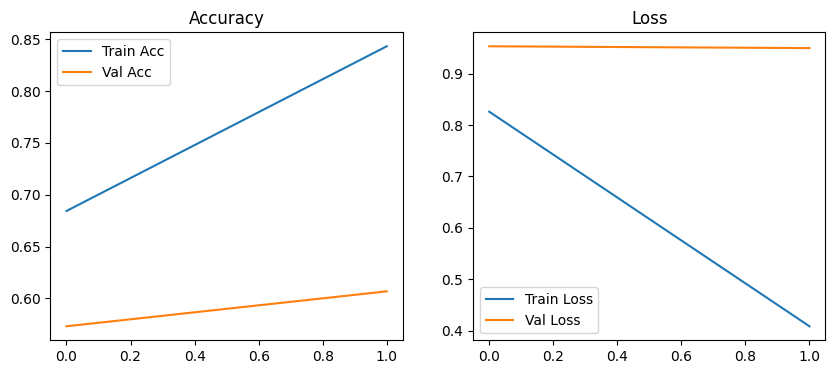

In [10]:
# 📊 Visualize Training
# ============================================================

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show

In [11]:
# ============================================================
# Test with One Image (Fixed Label Mapping)
# ============================================================

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load trained model
test_model = load_model(MODEL_SAVE_PATH)

# ✅ Get class labels in correct order
class_labels = list(train_gen.class_indices.keys())
print("Class Labels:", class_labels)

# Test Image Path
img_path = r"C:\Users\pavan\Downloads\cropDetection_cnn\Corn_Health (12).jpg"  # change if needed

# Load and preprocess
img = image.load_img(img_path, target_size=(128, 128))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

# Predict
pred = test_model.predict(x)
pred_index = np.argmax(pred, axis=1)[0]
confidence = np.max(pred) * 100

# ✅ Correct label from index
pred_label = class_labels[pred_index]

print(f"\n🌿 Predicted Class: {pred_label}")
print(f"Confidence: {confidence:.2f}%")


Class Labels: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
1/1 [==============================] - 1s 1s/step

🌿 Predicted Class: Healthy
Confidence: 90.47%


In [13]:
# model saving to path 
model.save("mobile_corn_model.h5")
print(f"model saved :",{model})

model saved : {<keras.engine.sequential.Sequential object at 0x000001872D4D9E20>}


In [14]:
# converting to  tensor flow lite

import tensorflow as tf

model = tf.keras.models.load_model("mobile_corn_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the mobile version
with open("mobile_corn_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved: mobile_corn_model.tflite")


INFO:tensorflow:Assets written to: C:\Users\pavan\AppData\Local\Temp\tmp5hbpwg_7\assets


INFO:tensorflow:Assets written to: C:\Users\pavan\AppData\Local\Temp\tmp5hbpwg_7\assets


✅ TFLite model saved: mobile_corn_model.tflite
